# NDVI Tutorial - Martin Holicka and Alex McVittie

## Purpose of this tutorial

This tutorial will use geospatial python libraries and numpy to assess distribution of vegetation using satellite imagery datasets. 





## Introduction to Remote Sensing

> â€œRemote sensing is the acquisition of information about
an object or phenomenon without making physical
contact with the object and thus in contrast to on-site
observation.â€

* Typically refers to satellite data
    â€“ Can also be done using drones or weather balloons


* Multiple types of data

    â€“ Typically raster (imagery) data    
    â€“ LiDAR data is a good example of non-raster data
    
    
* Point cloud data

#### Setup

If you want to follow along, you will need: 

GDAL:
* Linux: the system-wide package python3-gdal (sudo apt install python3-gdal)
* Anaconda: conda install gdal

numpy
* pip3 install numpy 

matplotlib (Optional for viewing output in iPython notebook
* pip3 install matplotlib
    
    

## Applications of Remote Sensing 

* Sea ice monitoring
* Land cover change
* Permafost melt
* Effects of natural disasters
* Determining tree and building heights

## Types of raster data

* Multispectral
    * Aerial photography (Three bands, RGB)
    

* LANDSAT data (Five to seven bands, covering different parts of the electromagnetic spectrum)


* Hyperspectral
    * 200+ bands
    * Hyperion sensor


* RADAR imagery
    * Microwave data




## Purpose of Different bands

* Each band of an image contains radiation captured at different wavelengths (IR, NIR, SWIR,RGB)
* Useful because different things on the ground will absorb and reflect at different wavelengths
* Since water will absorb all incoming NIR radiation, it will be pitch black. (Value of 0 => Null so that all calculations will be non-zero)




## Data Gathering and Metadata Analysis

The data for this tutorial can be downloaded from http://alexmcvittie.me/ipython/landsat_data.zip

While many geospatial products are not free, there is a large amount that is free. For this tutorial, we will use the LANDSAT 7 data that is acquired from USGS (United States Geographic Survey).  Let's examine the data

In [9]:
import gdal, numpy, math, os, random
import matplotlib.pyplot as plt

band3_raw = os.path.join("landsat_data", "LE07_L1TP_019030_20010830_20160929_01_T1_B3.TIF")
band4_raw = os.path.join("landsat_data", "LE07_L1TP_019030_20010830_20160929_01_T1_B4.TIF")
dataset = gdal.Open(band3_raw, gdal.GA_ReadOnly)
if dataset:
    print("Size is {} x {} x {}".format(dataset.RasterXSize,
                                    dataset.RasterYSize,
                                    dataset.RasterCount))
    print("Projection is {}".format(dataset.GetProjection()))

    

Size is 8011 x 7301 x 1
Projection is PROJCS["WGS 84 / UTM zone 17N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-81],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32617"]]


## Calculating NDVI

* Normalized Differential Vegetation Index
     â€œThe Normalized Differential Vegetation Index (NDVI) is a standardized vegetation index which allows us to generate an
image showing the relative biomass. The chlorophyll absorption in
Red band and relatively high reflectance of vegetation in Near
Infrared band (NIR) are using for calculating NDVI.â€ (ESRI)

* Outputs an image with float values [-1, 1]
   High values signify areas with high biomass concentration
    Low values signify areas with little to no biomass (water, concrete)

Band Designation:
![Band Designation](https://puu.sh/zQC3W/5999fa1a96.png)

The NDVI calculation is as follows :
![Formally](https://puu.sh/zQBZ9/71a4820524.png)


This tutorial package provides only bands 3 and 4, however all bands can be downloaded through USGS EarthExplorer. 





## Pre-Processing - Set 0 value to NoData

We mentioned above that all zero values need to be in NoData. For this, we will use the GDAL tool. We are only interested in Bands 3 and 4 (red and NIR).



In [10]:
def fix_nodata(raster):
    conn = gdal.Open(raster)
    fix = gdal.Translate(raster.replace(".TIF", "_nodata_fixed.TIF"), conn,noData=0)
    return raster.replace(".TIF", "_nodata_fixed.TIF")
band3_nozero = fix_nodata(band3_raw)
band4_nozero = fix_nodata(band4_raw)

To work with GeoTiffs in Python, we must use GDAL to convert the images to NumPy arrays. You can specify a numpy datatype, but by default it will read in as a float. 

In [11]:
def RasterToNumPyArray(raster_path, dtype=None):
    if dtype == None:
        return gdal.Open(raster_path).ReadAsArray()
    else:
        return gdal.Open(raster_path).ReadAsArray().astype(dtype)
band3_nparr = RasterToNumPyArray(band3_nozero)
band4_nparr = RasterToNumPyArray(band4_nozero)

## Pre-Processing - Convert DN to radiance data

DN (digital numbers) must be converted into radiance using the following formula:

![](https://puu.sh/zQCpB/ef13ec3ba2.png)

The numbers are gathered from certain advanced parts of the metadata anaysis.

For this dataset, the numbers are :

![](https://puu.sh/zQCur/a4bfc79057.png)

In [12]:
def dn_to_radiance(band, band_number):
    gain = {3:0.621654, 4:0.639764}
    bias = {3:-5.62, 4:-5.74}
    radiance = band * gain[band_number]  + bias[band_number]
    return radiance 
band3_radiance = dn_to_radiance(band3_nparr, 3)
band4_radiance = dn_to_radiance(band4_nparr, 4)

## Pre-Processing - Convert radiance to reflectance

First, let's define in general terms what radiance and reflectance is 

* Radiance = Illumination
* Reflectance = How much stuff got reflected back

We are going to need the sun angle, and we can get this from the metadata with the following function


In [14]:
def get_sun_angle(metadata_file):
    f = open(metadata_file, 'r')
    metadata = f.read().split("\n")
    for line in metadata:
        if "SUN_ELEVATION" in line:
            f.close()
            return float(line.split("=")[1].strip())
sun_angle = get_sun_angle(os.path.join("landsat_data", "LE07_L1TP_019030_20010830_20160929_01_T1_MTL.txt"))        

def get_earth_sun_distance(metadata_file):
    f = open(metadata_file, 'r')
    metadata = f.read().split("\n")
    for line in metadata:
        if "EARTH_SUN_DISTANCE" in line:
            f.close()
            return float(line.split("=")[1].strip())

earth_sun_distance = get_earth_sun_distance(os.path.join("landsat_data", "LE07_L1TP_019030_20010830_20160929_01_T1_MTL.txt"))

In order to convert it, we will use the following formula:

![](https://i.imgur.com/U6xfVzK.png)


where:  
*d* is the earth-sun distance obtained from metadata

E_sunÎ» is the band-specific radiance emitted by the sun obtained from advanced metadata

![](https://i.imgur.com/CT4BrDd.png)

Î¸ is the solar elevation angle. Metadata has it in degrees so it must be converted to radians. 

In [15]:
def radiance_to_reflectance(band, band_number, sun_angle, earth_sun_distance):
    sun_radiance = {3:0.621654, 4:0.639764}
    numerator = math.pi * band * (earth_sun_distance ** 2)
    denominator = sun_radiance[band_number] * math.sin(sun_angle * math.pi / 180)
    reflectance = numerator / denominator
    return reflectance
band3_reflectance = radiance_to_reflectance(band3_radiance, 3, sun_angle, earth_sun_distance)
band4_reflectance = radiance_to_reflectance(band4_radiance, 4, sun_angle, earth_sun_distance)

## Pre-Processing - Enforce positive reflectances

Since energy cannot be reflected negatively, we will set any values less that 0 to be 0. As well, to avoid divisions by zero, all zero values are set to a very small decimal number with the random function.

In [16]:

def enforce_positive_reflectance(band):
    band[numpy.where(band < 0)] = 0 
    band[numpy.where(band == 0)] = random.random() * 0.001
    return band

band3_allpos = enforce_positive_reflectance(band3_reflectance)
band4_allpos = enforce_positive_reflectance(band4_reflectance)




## NDVI Calculation

In [17]:
def calculate_ndvi(band3, band4):
    ndvi = (band4 - band3) / (band4 + band3)
    return ndvi
ndvi = calculate_ndvi(band3_allpos, band4_allpos)

## Looking at Results

Using MatPlotLib, we can view the NDVI output within our iPython notebook. Dark blue areas have low vegetation (The water) whereas the lighter green and yellow areas have higher amounts of vegetation. The value range is shown on the scale bar on the right, normalized between -1 and 1.

The NumPy array could be saved to a GeoTIFF using GDAL and further analyzed in a GIS program such as QGIS, GRASS, or SAGA. 

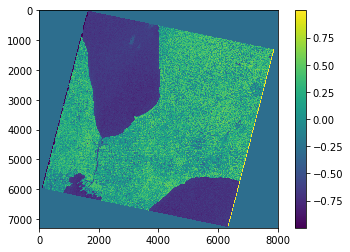

In [18]:

def display_ndvi(ndvi_arr):
    im = plt.imshow(ndvi_arr)
    plt.colorbar(im)
display_ndvi(ndvi)

## Exporting the NDVI array to a GeoTIFF for analysis in a GIS program

To export, we need to give GDAL information as to where to place the array, and how big each pixel should be in the final GeoTIFF. This information can be extracted from the original GeoTIFF using a few helper functions. 

To get the projection of the original GeoTIFF, we can use the following function:

In [19]:
def getProjection(in_raster_path):
    return gdal.Open(in_raster_path).GetProjection()

proj = getProjection(band3_raw)

To get the information on cell size and location, we get what is called a GeoTransform object from GDAL as follows:

In [20]:
def getGeoTransform(in_raster_path):
    return gdal.Open(in_raster_path).GetGeoTransform()
geot = getGeoTransform(band3_raw)

Finally, we can supply the NDVI array to GDAL and write to a GeoTIFF.

In [24]:
from osgeo import gdal_array

def NumPyArrayToRaster(nparr, proj, geot, out_raster_path, dtype=None):
    gdal.AllRegister()
    np_dt = nparr.dtype 
    if dtype == None:
        dtype = gdal_array.NumericTypeCodeToGDALTypeCode(np_dt)

    # Check if working with multiband raster
    if len(nparr.shape) == 3:
        n_bands = nparr.shape[0] 
        for x in range(0, n_bands):
            driver = gdal.GetDriverByName('GTIFF')
            outDs = driver.Create(out_raster_path, nparr.shape[2], nparr.shape[1], n_bands, dtype,
                                  ['COMPRESS=LZW', 'TILED=YES', 'BLOCKXSIZE=128', 'BLOCKYSIZE=128'])
            outDs.GetRasterBand(x + 1).WriteArray(nparr[x])
            outDs.GetRasterBand(x + 1).FlushCache()
            outDs.SetProjection(proj)
            outDs.SetGeoTransform(geot)

            outDs = None
    else:
        driver = gdal.GetDriverByName('GTIFF')
        outDs = driver.Create(out_raster_path, nparr.shape[1], nparr.shape[0], 1, dtype,
                              ['COMPRESS=LZW', 'TILED=YES', 'BLOCKXSIZE=128', 'BLOCKYSIZE=128'])
        outDs.GetRasterBand(1).WriteArray(nparr)
        outDs.GetRasterBand(1).FlushCache()
        outDs.SetProjection(proj)
        outDs.SetGeoTransform(geot)
        outDs = None

out_tif = "final_ndvi.tif"
NumPyArrayToRaster(ndvi, proj, geot, out_tif)

![](https://i.imgur.com/tM0mJ8w.png)

As we can see, our file *final_ndvi.tif* loads in just fine into QGIS. 

![](https://i.imgur.com/aSkldI7.png)

Zooming in, we can see detail of where different farmers fields start and end, and clearly identify where water is located. 

![](https://i.imgur.com/RbYVrhC.png)

Urban areas have a much lower NDVI score than their surrounding rural counterparts, and as such have a darker gray colour assigned.
